# Unsupervised Learning using Heart Disease Data

##  Problem Definition
This is a project to use Kaggle's K-Means Clustering for Heart Disease Analysis to do exploratory data analysis (EDA), model building and training, and comparison with unsupervised learning. 
In this case, the problem we will be exploring is **k-means clustering**. 

Information about the competition can be found at https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis/overview.
The goal will be to identify clusters of patients that have similar attributes in order to facilitate targeted treatment strategies for heart disease.

### Dataset Information
The data is from the Kaggle competition. It has anonymized patient data for people that have received a diagnosis of heart disease. The data includes things like patient ID, age, sex, origin of the dataset, chest pain type, and other medicial information. The total number of columns is 15.

amirabwd18, Azzedine Idir Aitsaid, Mohcen Chouireb, Omar Farouk Zouak. (2023). K-Means Clustering for Heart Disease Analysis. Kaggle. https://kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.stats import skew
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Fetch dataset 
data = pd.read_csv('heart_disease.csv')

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
I will view the data and determine if it needs cleaning. 

The features in the data are as follows:

1. 	id       Discrete 	id of the patient
2. 	age 	 Discrete 	age 	years
3. 	sex 	 Categorical 	sex of the patient (1=male, 0=female) 	
4. 	dataset  Categorical 	origin of instance 	
5. 	cp  	 Categorical 	chest pain type 	
6. 	trestbps Discrete 	resting blood pressure 	mm Hg
7. 	chol 	 Discrete 	cholesterol measurement 	mg/dl
8. 	fbs 	 Categorical 	fasting blood sugar > 120 mg/dl 	
9. restecg 	 Categorical 	resting electrocardiographic results 	
10. thalach  Discrete 	maximum heart rate achieved 	
11. exang 	 Categorical 	exercise induced angina (1 = yes, 0 = no) 	
12. oldpeak  Discrete 	ST depression induced by exercise relative to rest 	
13. slope 	 Categorical 	slope of the peak exercise ST segment 	
14. ca 	     Discrete 	number of major vessels (0-3) 	
15. thal 	 Categorical 	a blood disorder called thalassemia

In [3]:
print(data.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   0   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   1   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   2   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   3   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   4   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca               thal  
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0       fixed defect  
1  lv hypertrophy   108.0   True      1.5         flat  3.0             normal  
2  lv hypertrophy   129.0   True      2.6         flat  2.0  reversable defect  
3          normal   187.0  False      3.5  downsloping  0.0             normal  
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0             normal  


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
None


The dtypes for the columns are as expected, so need to fix anything there. 

Next lets see if there are any nulls.

In [5]:
data.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

There is quite a bit of missing data for ca and thal. I think there are too many to just remove the nulls. Let's view the distrubtion of the data to decide what to do with these columns.

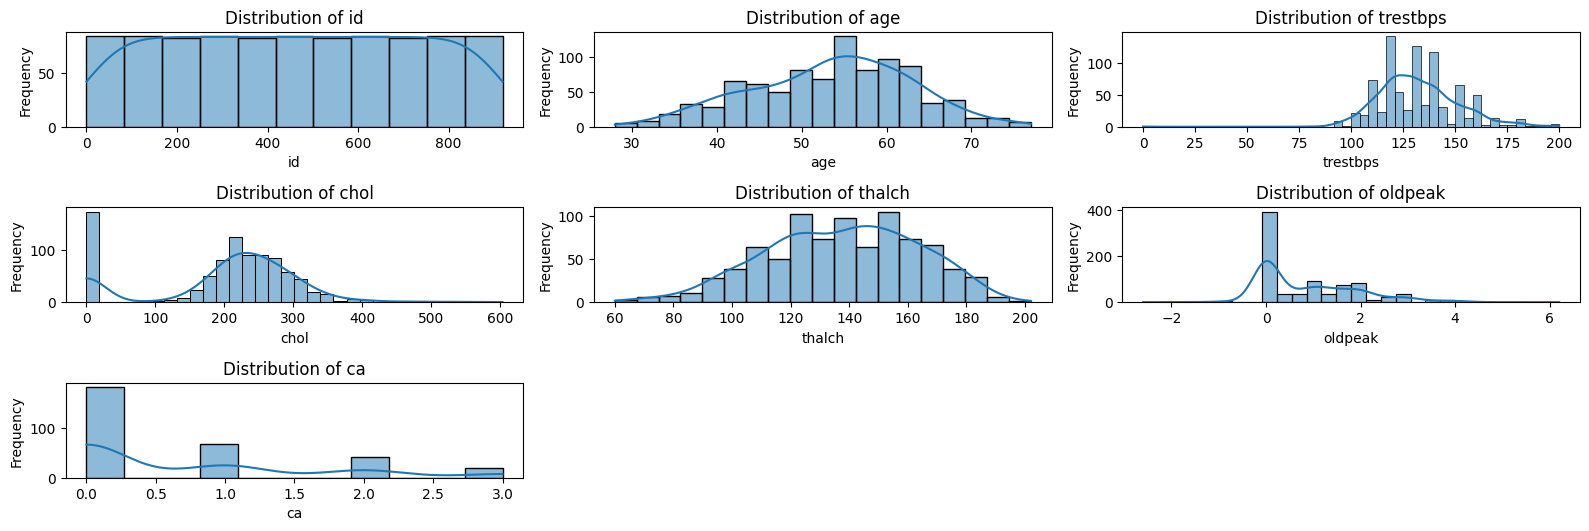

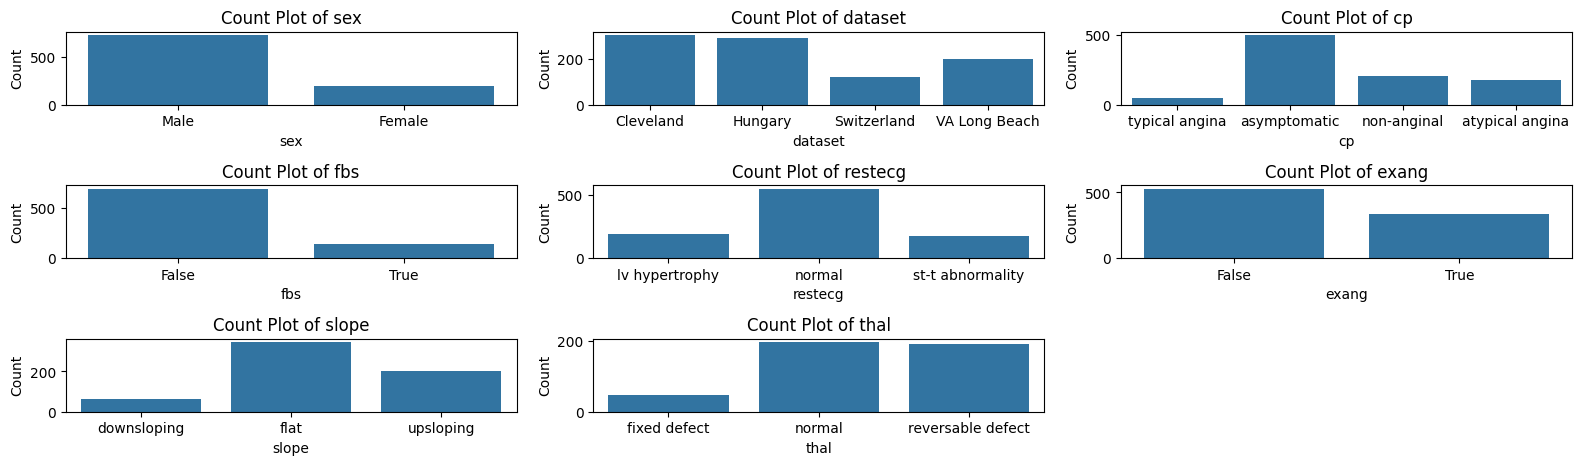

In [6]:
# Break down the numeric and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Visualizing Numerical Data Distribution
plt.figure(figsize=(16, 12))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 3, i)
    sns.histplot(data[col].dropna(), kde=True)  # Histogram with KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualizing Categorical Data Distribution
plt.figure(figsize=(16, 12))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 3, i)
    sns.countplot(x=col, data=data)
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

It looks like most the of the data isn't evenly distrubted. I think we should try KNN imputation rather than something simple like mean or randomly choosing for categorical, since there isn't that much data in the first place and in some cases over half of it is missing. We will need to encode the categorical data.

In [11]:
# Separate numeric and categorical columns
numeric_df = data.select_dtypes(include=['int64', 'float64'])
categorical_df = data.select_dtypes(include=['object'])

# Encode categorical data using Label Encoding
label_encoders = {}
for col in categorical_df.columns:
    le = LabelEncoder()
    categorical_df[col] = le.fit_transform(categorical_df[col].astype(str))
    label_encoders[col] = le

# Combine encoded categorical data with numeric data
combined_df = pd.concat([numeric_df, categorical_df], axis=1)

# Impute
imputer = KNNImputer(n_neighbors=5)
imputed_df = pd.DataFrame(imputer.fit_transform(combined_df), columns=combined_df.columns)

print(imputed_df.isnull().sum())

id          0
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
ca          0
sex         0
dataset     0
cp          0
fbs         0
restecg     0
exang       0
slope       0
thal        0
dtype: int64


All of the null values have been converted. Let's take a look at the correlation matrix now and skewness.

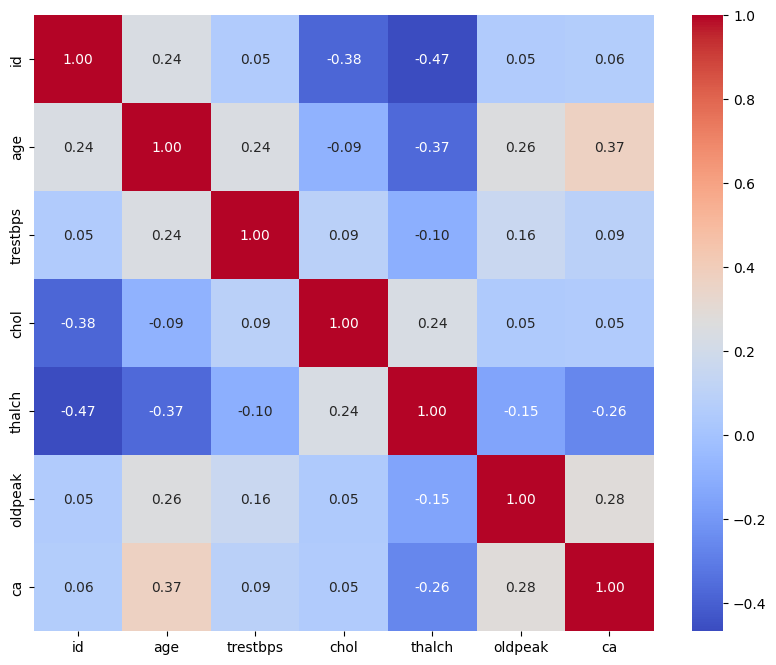

Skewness of features:
 id          0.000000
age        -0.195674
trestbps    0.191264
chol       -0.649518
thalch     -0.146888
oldpeak     0.954501
ca          0.749028
dtype: float64


In [12]:
# Calculate the correlation matrix using only numeric columns
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Check skewness of numeric features
numeric_cols = numeric_df.columns
skewness = imputed_df[numeric_cols].apply(lambda x: skew(x.dropna()))
print("Skewness of features:\n", skewness)

None of the columns are particularly overly correlated with any of the others because they are all well under 0.7. Ca is pretty right-skewed. We should probably do a transformation to help it. Oldpeak is also pretty right-skewed but it contains negative values. Let's do a square root transformation since it's less aggressive than log transformation. We will need to shift oldpeak so that it only has positive values. We should also normalize the data since it has varying ranges of values.

In [13]:
# Shift the 'oldpeak' values to ensure all are non-negative
min_value = imputed_df['oldpeak'].min()
if min_value < 0:
    shift_value = abs(min_value)
    imputed_df['oldpeak_shifted'] = imputed_df['oldpeak'] + shift_value
else:
    imputed_df['oldpeak_shifted'] = imputed_df['oldpeak']

# Apply square root transformation to `oldpeak` and `ca`
imputed_df['oldpeak_sqrt'] = np.sqrt(imputed_df['oldpeak_shifted'])
imputed_df['ca_sqrt'] = np.sqrt(imputed_df['ca'])

# Normalize the numeric data, excluding the `ID` column
# Select the numeric columns to be normalized (excluding 'ID' and original `oldpeak` and `ca`)
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak_sqrt', 'ca_sqrt']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to the selected columns
imputed_df[numeric_cols] = scaler.fit_transform(imputed_df[numeric_cols])

# Display the first few rows of the transformed and normalized data
imputed_df = imputed_df.drop(columns=['id', 'oldpeak', 'oldpeak_shifted', 'ca'])
print(imputed_df.head())

        age  trestbps      chol    thalch  sex  dataset   cp  fbs  restecg  \
0  0.714286     0.725  0.386401  0.633803  1.0      0.0  3.0  1.0      0.0   
1  0.795918     0.800  0.474295  0.338028  1.0      0.0  0.0  0.0      0.0   
2  0.795918     0.600  0.379768  0.485915  1.0      0.0  0.0  0.0      0.0   
3  0.183673     0.650  0.414594  0.894366  1.0      0.0  2.0  0.0      2.0   
4  0.265306     0.650  0.338308  0.788732  0.0      0.0  1.0  0.0      0.0   

   exang  slope  thal  oldpeak_sqrt   ca_sqrt  
0    0.0    0.0   0.0      0.746203  0.000000  
1    1.0    1.0   2.0      0.682575  1.000000  
2    1.0    1.0   3.0      0.768706  0.816497  
3    0.0    0.0   2.0      0.832575  0.000000  
4    0.0    3.0   2.0      0.674200  0.000000  


Looks good. I'm not really sure which features will be more important for informing the model, but since age had no nulls that's probably important. I'm concerned that the sex distrubtion is an atrifact of the way that data was collected, so I'm not sure how important it will be. It's also a little concerning that there were so many 0 values for cholestorol, but I'd expect that to be a significant factor as well. Thalch (Discrete maximum heart rate achieved) seems to have the strongest correlation to the other variables so I don't think it'll be that useful. 

Let's jump into training the model now and see if any of my hunches are supported.

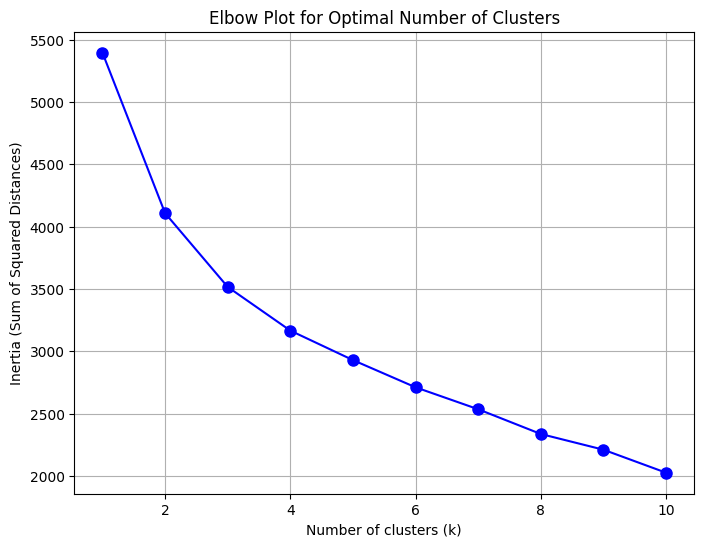

In [14]:
X = imputed_df.copy()
# Run KMeans for a range of clusters and calculate inertia
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Create the Elbow Plot
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.grid(True)
plt.show()

I think 3 looks good for cluster size. 

              age  trestbps      chol    thalch       sex   dataset        cp  \
cluster                                                                         
0        0.606580  0.662268  0.189301  0.442067  0.952681  2.630915  0.552050   
1        0.424085  0.663344  0.409321  0.559578  0.687307  0.873065  0.845201   
2        0.534694  0.658411  0.407842  0.632319  0.721429  0.082143  0.971429   

              fbs   restecg     exang     slope      thal  oldpeak_sqrt  \
cluster                                                                   
0        0.741325  2.192429  0.804416  1.545741  1.397476      0.642051   
1        0.126935  2.123839  0.306502  1.609907  1.030960      0.605450   
2        0.150000  0.928571  0.332143  2.007143  2.421429      0.627922   

          ca_sqrt  
cluster            
0        0.634404  
1        0.310493  
2        0.313597  


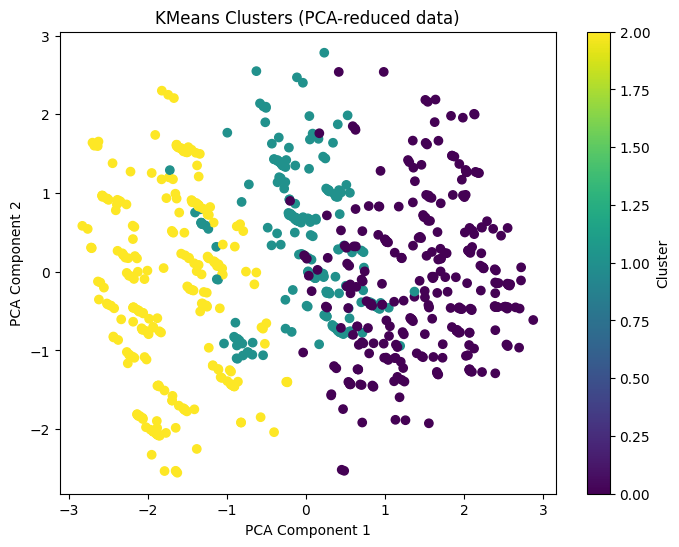

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
imputed_df['cluster'] = kmeans.fit_predict(X)

cluster_profile = imputed_df.groupby('cluster').mean()
print(cluster_profile)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=imputed_df['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clusters (PCA-reduced data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

The clusters don't look bad but let's see if we can get it any better by using gridsearch to optimize the parameters.

In [17]:
# Define a function to evaluate KMeans with silhouette score
def kmeans_silhouette_score(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Set up the parameter grid for GridSearch
param_grid = {
    'n_clusters': range(2, 15),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],  # Number of initializations to test
    'max_iter': [300, 600],  # Maximum number of iterations
    'random_state': [42]
}

# Initialize KMeans
kmeans = KMeans()

# Set up GridSearchCV
grid_search = GridSearchCV(kmeans, param_grid, scoring=kmeans_silhouette_score, cv=5, n_jobs=-1)
grid_search.fit(X)

# Best parameters and silhouette score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best silhouette score: {best_score:.4f}")

Best parameters found: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 20, 'random_state': 42}
Best silhouette score: 0.3158


Silhouette score thinks that a clustering of 10 would be better but it's a still pretty low score. Let's take a look at the clusters with the optimized parameters.

        age  trestbps      chol    thalch  sex  dataset   cp  fbs  restecg  \
0  0.714286     0.725  0.386401  0.633803  1.0      0.0  3.0  1.0      0.0   
1  0.795918     0.800  0.474295  0.338028  1.0      0.0  0.0  0.0      0.0   
2  0.795918     0.600  0.379768  0.485915  1.0      0.0  0.0  0.0      0.0   
3  0.183673     0.650  0.414594  0.894366  1.0      0.0  2.0  0.0      2.0   
4  0.265306     0.650  0.338308  0.788732  0.0      0.0  1.0  0.0      0.0   

   exang  slope  thal  oldpeak_sqrt   ca_sqrt  cluster  
0    0.0    0.0   0.0      0.746203  0.000000        3  
1    1.0    1.0   2.0      0.682575  1.000000        5  
2    1.0    1.0   3.0      0.768706  0.816497        5  
3    0.0    0.0   2.0      0.832575  0.000000        3  
4    0.0    3.0   2.0      0.674200  0.000000        0  


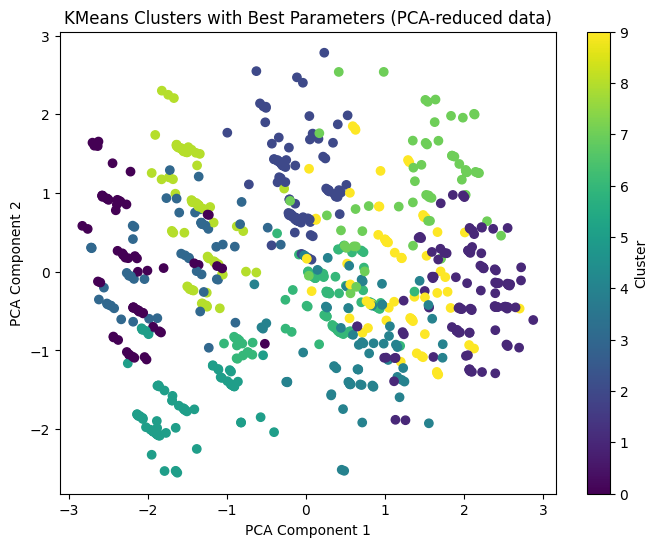

        age  trestbps      chol    thalch       sex   dataset        cp  \
0  0.516698  0.660530  0.425549  0.681818  0.681818  0.075758  1.060606   
1  0.634597  0.674754  0.307834  0.453119  0.976190  2.944444  0.095238   
2  0.383593  0.655395  0.390761  0.615715  0.625000  1.000000  1.447368   
3  0.556901  0.658475  0.393007  0.647649  0.711864  0.067797  2.169492   
4  0.580499  0.687778  0.102018  0.383685  0.916667  2.194444  0.180556   
5  0.571926  0.663963  0.417344  0.521470  0.719512  0.048780  0.085366   
6  0.463822  0.677622  0.427958  0.486506  0.804196  0.839161  0.055944   
7  0.619048  0.651587  0.229561  0.445585  0.984127  2.888889  2.158730   
8  0.489092  0.641954  0.394655  0.717258  0.666667  0.057471  1.195402   
9  0.531195  0.624357  0.077077  0.480080  0.871429  1.971429  0.314286   

        fbs       restecg     exang     slope      thal  oldpeak_sqrt  \
0  0.166667 -1.332268e-15  0.227273  2.909091  2.045455      0.580528   
1  0.349206  2.357143e+00  1

In [18]:
# Use the best parameters to create a new KMeans model
kmeans_best = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init'],
    n_init=best_params['n_init'],
    max_iter=best_params['max_iter'],
    random_state=best_params['random_state']
)

# Fit the model and predict cluster labels
imputed_df['cluster'] = kmeans_best.fit_predict(X)

# View the first few rows with the assigned clusters
print(imputed_df.head())

# Step 3: Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=imputed_df['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clusters with Best Parameters (PCA-reduced data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Examine cluster centroids
centroids = pd.DataFrame(kmeans_best.cluster_centers_, columns=X.columns)
print(centroids)

The clusters don't look well defined to me. The silhouette score was also a bit low, at .3.

As far as the variables go, cholesterol centroids vary from 0.07 to 0.43, suggesting that it's an important feature for distinguishing clusters. Thalch also has some noticiable variation. Same with oldpeak and ca. This is somewhat what I expected from the correlation matrix and histograms of feature data.

Maybe a different model would look a bit better in terms of well-defined clusters. I'll try hierarchical clustering.

Number of clusters: 2, Silhouette Score: 0.2325
Number of clusters: 3, Silhouette Score: 0.1596
Number of clusters: 4, Silhouette Score: 0.1838
Number of clusters: 5, Silhouette Score: 0.1995
Number of clusters: 6, Silhouette Score: 0.2135
Number of clusters: 7, Silhouette Score: 0.2196
Number of clusters: 8, Silhouette Score: 0.2269
Number of clusters: 9, Silhouette Score: 0.2406
Number of clusters: 10, Silhouette Score: 0.2467

Optimal number of clusters: 10 with a Silhouette Score of 0.2467


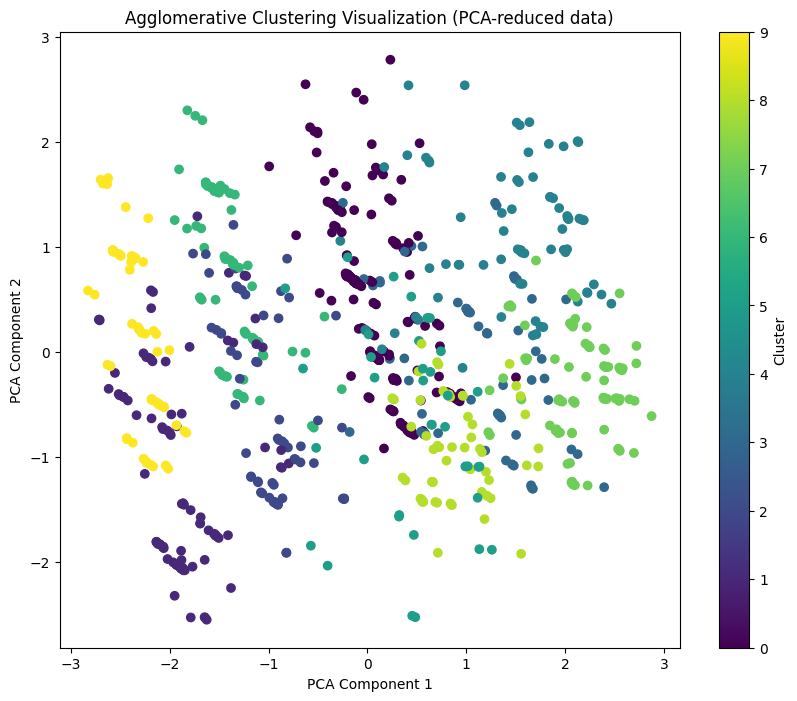

In [19]:
# Initialize variables to store the best score and the corresponding number of clusters
best_score = -1
best_n_clusters = 2

# Iterate over a range of cluster numbers
for n_clusters in range(2, 11):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agg_clustering.fit_predict(X)
    
    # Compute the silhouette score for this number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")
    
    # Update best score and best number of clusters if this is the best so far
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

# Output the best number of clusters
print(f"\nOptimal number of clusters: {best_n_clusters} with a Silhouette Score of {best_score:.4f}")

# Use the optimal number of clusters found during optimization
agg_clustering_best = AgglomerativeClustering(n_clusters=best_n_clusters)

# Fit the model and predict cluster labels
imputed_df['agg_cluster'] = agg_clustering_best.fit_predict(X)

# Step 1: Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=imputed_df['agg_cluster'], cmap='viridis', marker='o')
plt.title('Agglomerative Clustering Visualization (PCA-reduced data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

The silhouette score is even worse and the clusters seem to be even less defined. This method was definitely not an improvement. 

## Conclusion
The kmeans clustering outperformed agglormerative clustering in this dataset, however neither was particularly stellar at grouping patients. KMeans produced clusters that were moderately well-defined with a silhouette score wround 0.3. However, there was some overlap between clusters, indicating that the clusters aren't well seperated. It might be okay to identify patient groups with distinct characteristics. The agglomerative clustering had a slightly lower silhouette score at 0.24, so the clusters were less well-defined. Because it's hierarchical it likely had more complex cluster boundries which could have led to a lower score. It might discover subgroups within the patient population, but these clusters aren't easily interpretable as Kmeans. 

Given the goal of identifying patient clusters for targeted heart disease treatment, KMeans appears to be more effective here. It produced slightly better-defined clusters, making it easier to identify groups of patients with similar attributes. These groups can then be targeted with personalized treatment strategies, potentially improving patient outcomes.

However, Agglomerative Clustering's hierarchical nature might still offer valuable insights, particularly if there is a need to explore subgroups within the broader patient clusters. It could be worth exploring further, especially in cases where understanding the relationships between clusters is crucial.